# Preregistration: Evaluation of Clinical Benefit

Gaylen Fronk  
May 13, 2024

In [ ]:
study <- params$study
version <- params$version
y_col_name <- params$y_col_name

In [ ]:
#| message: false
#| warning: false

# packages for script
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Loading required package: lme4
Loading required package: Matrix

Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

ℹ SHA-1 hash of file is "b58b9e0adc05e89609ee8bc6f20c39375b262fe6"

In [ ]:
#| message: false
#| warning: false

# handle conflicts
options(conflicts.policy = "depends.ok")

In [ ]:
# absolute paths
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_models <- str_c("P:/studydata/match/models/", y_col_name)},
        
        # IOS paths
        Darwin = {
          path_models <- str_c("/Volumes/private/studydata/match/models/", y_col_name)},
        
        # Linux paths
        Linux = {
          path_models <- str_c("~/mnt/private/studydata/match/models/", y_col_name)}
)

In [ ]:
# chunk defaults

options(tibble.width = Inf)
options(tibble.print_max = Inf)

Read in aim 2 dataset

In [ ]:
d <- read_csv(file.path(path_models, 
                        str_c("aim_2_", version, "_", y_col_name, ".csv")),
              show_col_types = FALSE) |> 
  mutate(outcome_rct_wk4_num = if_else(outcome_rct_wk4 == "abstinent", 1, 0),
         outcome_rct_wk12_num = if_else(outcome_rct_wk12 == "abstinent", 1, 0),
         outcome_rct_wk26_num = if_else(outcome_rct_wk26 == "abstinent", 1, 0),
         tx_worst = case_when(
           prob_patch < prob_combo_nrt & prob_patch < prob_varenicline ~ "patch",
           prob_combo_nrt < prob_patch & prob_combo_nrt < prob_varenicline ~ "combo_nrt",
           prob_varenicline < prob_patch & prob_varenicline < prob_combo_nrt ~ "varenicline",
           TRUE ~ NA_character_),
         tx_second = case_when(
           tx_worst == "patch" & tx_best == "varenicline" ~ "combo_nrt",
           tx_worst == "patch" & tx_best == "combo_nrt" ~ "varenicline",
           tx_worst == "varenicline" & tx_best == "patch" ~ "combo_nrt",
           tx_worst == "varenicline" & tx_best == "combo_nrt" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "varenicline" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "patch" ~ "varenicline",
           TRUE ~ NA_character_)) |> 
  mutate(tx_rank = case_when(
    tx_rct == tx_best ~ "first",
    tx_rct == tx_second ~ "second",
    tx_rct == tx_worst ~ "third",
    TRUE ~ NA_character_)) |> 
  select(subid, starts_with("tx_"), starts_with("prob_"),
         outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) |> 
  pivot_longer(
    cols = c(outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num),
    names_to = "week",
    names_pattern = "(?<=outcome_rct_wk)(.+)(?=_num)",
    values_to = "outcome_rct_num"
  ) |> 
  mutate(c_tx_match = if_else(tx_match == TRUE, 0.5, -0.5), # center
         week = as.numeric(week)) |> 
  # log transformation
  mutate(week_log_2 = log(week, base = 2)) |> 
  # week 4-centered log transformation
  mutate(c4_week_log_2 = week_log_2 - log(4, base = 2))

glimpse(d)

Rows: 3,258
Columns: 16
$ subid            <dbl> 20010, 20010, 20010, 20015, 20015, 20015, 20030, 2003…
$ tx_rct           <chr> "patch", "patch", "patch", "combo_nrt", "combo_nrt", …
$ tx_best          <chr> "varenicline", "varenicline", "varenicline", "varenic…
$ tx_match         <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALS…
$ tx_worst         <chr> "combo_nrt", "combo_nrt", "combo_nrt", "patch", "patc…
$ tx_second        <chr> "patch", "patch", "patch", "combo_nrt", "combo_nrt", …
$ tx_rank          <chr> "second", "second", "second", "second", "second", "se…
$ prob_best        <dbl> 0.2646638, 0.2646638, 0.2646638, 0.4846121, 0.4846121…
$ prob_patch       <dbl> 0.2007715, 0.2007715, 0.2007715, 0.4175508, 0.4175508…
$ prob_combo_nrt   <dbl> 0.1845281, 0.1845281, 0.1845281, 0.4643572, 0.4643572…
$ prob_varenicline <dbl> 0.2646638, 0.2646638, 0.2646638, 0.4846121, 0.4846121…
$ week             <dbl> 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26…
$ outcome_rct_nu

## Analyses

### Primary model

*NOTE*: differs from preregistration (base 2 instead of base e)

4-week-centered, log-transformed week (base 2)

In [ ]:
if(file.exists(file.path(path_models, 
                         str_c("model_clin_benefit_", version, ".rds")))){
  message(str_c("Model already exists for version ", 
                version, ". Reading in existing model"))
  
  model_bayes <- read_rds(file.path(path_models, 
                                    str_c("model_clin_benefit_", version, ".rds")))
  
} else {
  message("Fitting new model & saving out")
  model_bayes <- blme::bglmer(outcome_rct_num ~ c_tx_match * c4_week_log_2 + 
                                (1 + c4_week_log_2 | subid),
                              data = d,
                              family = binomial(link = "logit"),
                              control = glmerControl(optCtrl = list(maxfun = 3e6)))
  
  model_bayes |> 
    write_rds(file.path(path_models, 
                        str_c("model_clin_benefit_", version, ".rds")))
}

Model already exists for version v5. Reading in existing model

Evaluate model

In [ ]:
summary(model_bayes)

Cov prior  : subid ~ wishart(df = 4.5, scale = Inf, posterior.scale = cov, common.scale = TRUE)
Prior dev  : -1.5157

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [bglmerMod]
 Family: binomial  ( logit )
Formula: outcome_rct_num ~ c_tx_match * c4_week_log_2 + (1 + c4_week_log_2 |  
    subid)
   Data: d
Control: glmerControl(optCtrl = list(maxfun = 3e+06))

     AIC      BIC   logLik deviance df.resid 
  3045.9   3088.6  -1516.0   3031.9     3251 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.60825 -0.32784 -0.06676  0.17412  1.59916 

Random effects:
 Groups Name          Variance Std.Dev. Corr
 subid  (Intercept)   3.977    1.994        
        c4_week_log_2 5.848    2.418    0.94
Number of obs: 3258, groups:  subid, 1086

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.05563    0.16229  -6.505 7.79e-11 ***
c_tx_match                1.46351    0.25949   5.640 1.7

### Follow-up analyses: Simple Effects

From preregistration: If the interaction between `tx_match` and `week` is significant (*p* \< 0.05), we will conduct follow-up analyses to test the simple effect of `tx_match` at each time point.

Interaction between `tx_match` and `week` was not significant (*p* = 0.83), so no follow-up analyses of simple effects are needed.

## Figure

`summarise()` has grouped output by 'week_cat'. You can override using the
`.groups` argument.

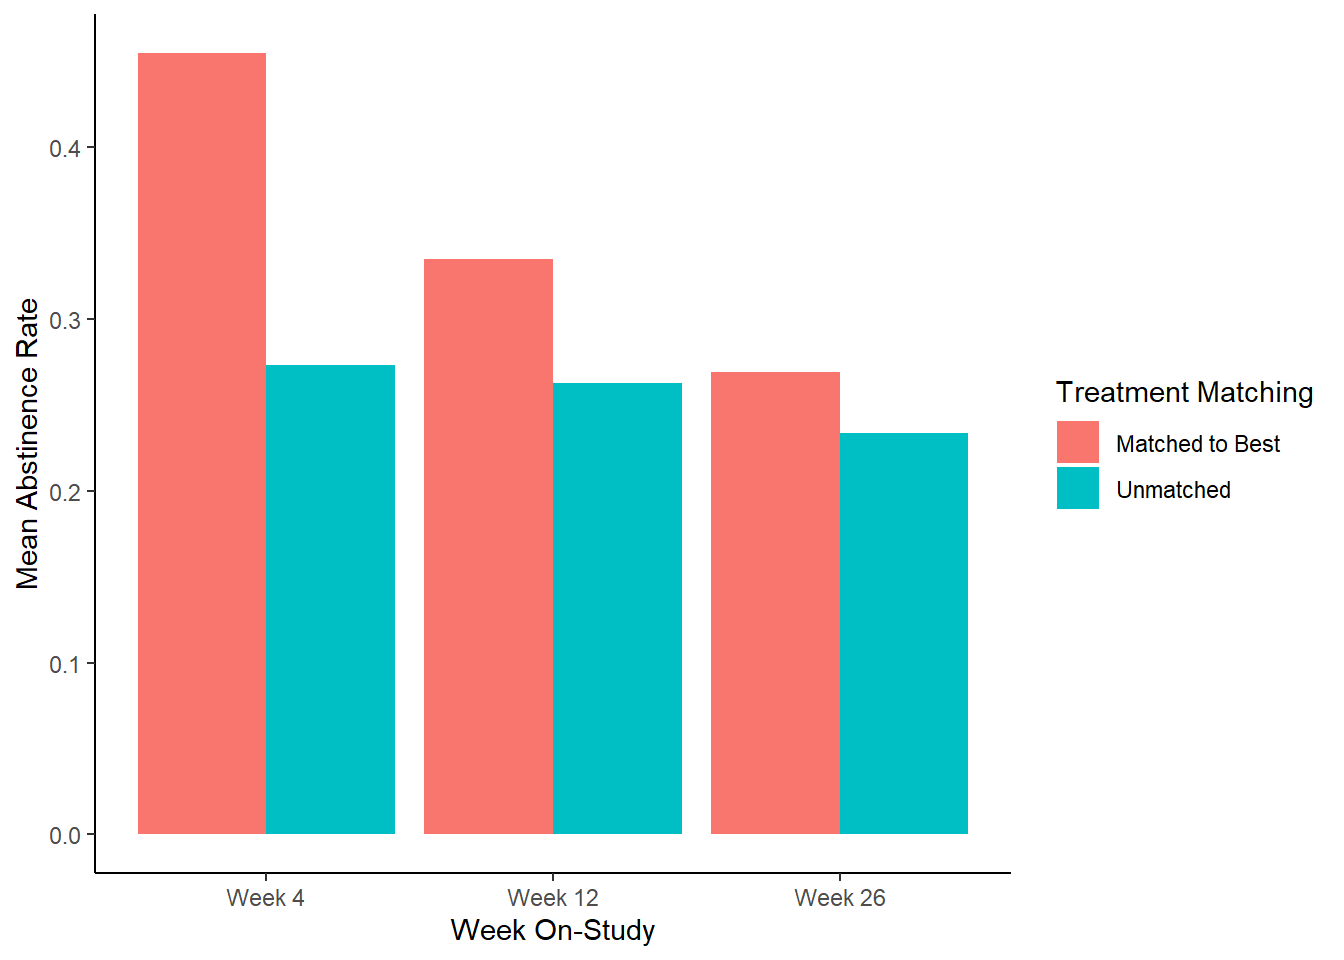

In [ ]:
#| label: fig-clin-ben-wk4
d |> 
  mutate(week_cat = factor(week,
                           levels = c(4, 12, 26),
                           labels = c("Week 4", "Week 12", "Week 26")),
         tx_match = factor(tx_match, 
                           levels = c(TRUE, FALSE),
                           labels = c("Matched to Best", "Unmatched"))) |> 
  group_by(week_cat, tx_match) |> 
  summarize(mean_outcome = mean(outcome_rct_num)) |> 
  ggplot(aes(x = week_cat, y = mean_outcome, fill = tx_match)) +
  geom_col(position = "dodge") +
  labs(
    x = "Week On-Study",
    y = "Mean Abstinence Rate",
    fill = "Treatment Matching"
  )